In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk
from sklearn.naive_bayes import ComplementNB
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer

from plotly.subplots import make_subplots
import plotly.graph_objects as go





from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score

from sklearn.model_selection import GridSearchCV

In [126]:
#  nltk.download("stopwords")
# nltk.download("punkt")
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('vader_lexicon')

In [127]:
# Read in data
df = pd.read_csv('Data/raw_clean_data.csv')
print(df.shape)

(20491, 3)


In [128]:
# We are adding a new columns 'Unique Id' which will be helpful in this SENTIMENT ANALYSIS
df = df.reset_index().rename(columns={'index': 'Unique Id'})

In [129]:
df.head()

,Unique Id,text,rating,Label
0,0,beautiful accomodations stayed hotel santa mar...,4,Positive
1,1,great hotel great location hotel located la ra...,5,Positive
2,2,beautiful hotel great location like beautifull...,4,Positive
3,3,great deal waikiki trip hawaii outrigger luana...,4,Positive
4,4,choose airport hotel busy triparound australia...,1,Negative


# Simple EDA

In [130]:
dfg=df.groupby('rating').count().reset_index()

In [131]:
# plot structure
fig = px.bar(dfg,
             x='rating',
             y='Unique Id', 
            labels = {'rating':'Ratings','Unique Id': 'Count'}, 
             text_auto=True, width=800, height=500)

fig.update_layout(
    title=dict(text="Count of Reviews by Ratings", font=dict(size=35), 
               automargin=True, yref='paper',font_color="Red"))
# plot
fig.show()

# NLP on Text

In [132]:
def process_doc(doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [133]:
df['text'][0]

'beautiful accomodations stayed hotel santa maria novella night wished stayed entirety days florence simply gorgeous accomodations, room stayed cheapest rate available assuming simplest abode offer beautiful hardwood floors bed linens comfortable mattress difficult italy drapes fantastic marble bathroom, nicer expecting especially price, location not central 10-minute walk sights close train station away noise bustle busier locations, close upscale shopping lots trattorias, nice oasis hectic sightseeing florence highly recommed hotel hotels higher ranked website,  '

In [134]:
process_doc(df['text'][0])

'beautiful accomodations stay hotel santa maria novella night wish stayed entirety day florence simply gorgeous accomodations room stay cheap rate available assume simple abode offer beautiful hardwood floor bed linens comfortable mattress difficult italy drape fantastic marble bathroom nicer expect especially price location central walk sight close train station away noise bustle busy location close upscale shopping lot trattorias nice oasis hectic sightsee florence highly recommed hotel hotel higher rank website'

In [135]:
df['text'] = df['text'].apply(process_doc)

In [136]:
df['text'][0]

'beautiful accomodations stay hotel santa maria novella night wish stayed entirety day florence simply gorgeous accomodations room stay cheap rate available assume simple abode offer beautiful hardwood floor bed linens comfortable mattress difficult italy drape fantastic marble bathroom nicer expect especially price location central walk sight close train station away noise bustle busy location close upscale shopping lot trattorias nice oasis hectic sightsee florence highly recommed hotel hotel higher rank website'

# NLTK's SentimentIntensityAnalyzer

In [137]:
sia = SentimentIntensityAnalyzer()

In [138]:
sia.polarity_scores('I am so mad at you!!')
# Test polarity_scores

{'neg': 0.505, 'neu': 0.495, 'pos': 0.0, 'compound': -0.6221}

In [139]:
sia.polarity_scores('I am so happy!!')

{'neg': 0.0, 'neu': 0.304, 'pos': 0.696, 'compound': 0.6785}

In [140]:
# Run the polarity score on the entire dataset
result = {}
for row in range(len(df)):
    text = df['text'][row]
    my_id = df['Unique Id'][row]
    result[my_id] = sia.polarity_scores(text)

In [141]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'Unique Id'})
vaders = vaders.merge(df, how='left')

In [142]:
vaders.head()

,Unique Id,neg,neu,pos,compound,text,rating,Label
0,0,0.027,0.677,0.296,0.9766,beautiful accomodations stay hotel santa maria...,4,Positive
1,1,0.033,0.507,0.460,0.9858,great hotel great location hotel locate la ram...,5,Positive
2,2,0.066,0.564,0.370,0.9834,beautiful hotel great location beautifully app...,4,Positive
3,3,0.015,0.670,0.315,0.9802,great deal waikiki trip hawaii outrigger luana...,4,Positive
4,4,0.430,0.570,0.000,-0.9442,choose airport hotel busy triparound australia...,1,Negative


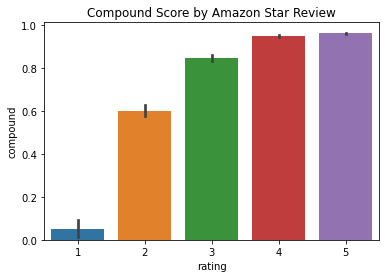

In [143]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound Score by Amazon Star Review');

In [144]:
vdf=vaders.groupby('rating').mean().reset_index()

In [145]:
vdf

,rating,Unique Id,neg,neu,pos,compound
0,1,10124.116819,0.170939,0.662748,0.166327,0.052167
1,2,10115.714445,0.115845,0.658262,0.225907,0.601179
2,3,10439.364469,0.080988,0.633248,0.285757,0.847032
3,4,10225.843683,0.052353,0.590403,0.357254,0.949921
4,5,10255.467970,0.038740,0.566361,0.394898,0.963386


In [146]:
# plot structure
fig = px.bar(vdf,
             x='rating',
             y='compound', 
            labels = {'rating':'Ratings','compound': 'Avg Compound Score'}, 
             text_auto=True, width=800, height=500)

fig.update_layout(
    title=dict(text="Avg Compound Score by Rating", font=dict(size=35), 
               automargin=True, yref='paper',font_color="Red"))
# plot
fig.show()

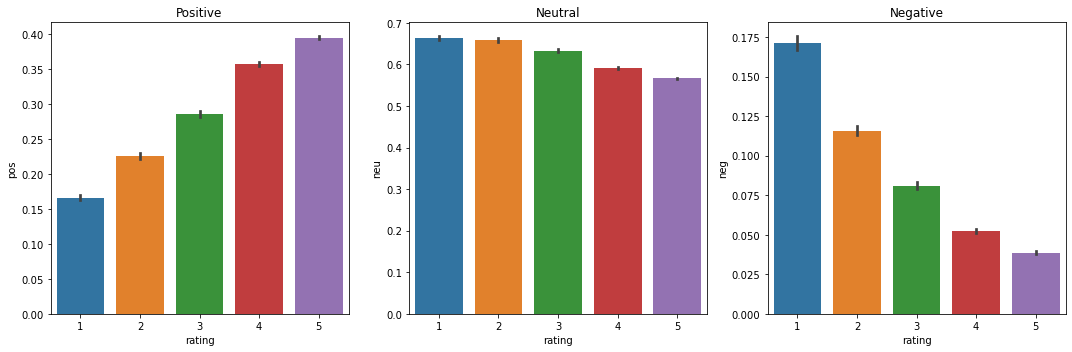

In [147]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()

In [148]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Postive", "Neutral", "Negative"))

fig.add_trace(
    go.Bar(x=vdf['rating'].values, y=vdf['pos'].values),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=vdf['rating'].values, y=vdf['neu'].values),
    row=1, col=2
)


fig.add_trace(
    go.Bar(x=vdf['rating'].values, y=vdf['neg'].values),
    row=1, col=3,
)

fig.update_xaxes(title_text="Ratings", row=1, col=2)



fig.update_traces(marker_color='#20C038',row=1, col=1)
fig.update_traces(marker_color='#F5CD09',row=1, col=2)
fig.update_traces(marker_color='#E5354D',row=1, col=3)

fig.update_layout(height=550, width=1000, title=dict(text="Connotation Scores", 
                                                     font=dict(size=25),font_color="Black"))
fig.show()

# Model with the Sentiment Analysis

In [149]:
le = LabelEncoder()
vaders['Label'] = le.fit_transform(vaders['Label'])

In [150]:
vaders

,Unique Id,neg,neu,pos,compound,text,rating,Label
0,0,0.027,0.677,0.296,0.9766,beautiful accomodations stay hotel santa maria...,4,1
1,1,0.033,0.507,0.460,0.9858,great hotel great location hotel locate la ram...,5,1
2,2,0.066,0.564,0.370,0.9834,beautiful hotel great location beautifully app...,4,1
3,3,0.015,0.670,0.315,0.9802,great deal waikiki trip hawaii outrigger luana...,4,1
4,4,0.430,0.570,0.000,-0.9442,choose airport hotel busy triparound australia...,1,0
...,...,...,...,...,...,...,...,...
20486,20486,0.033,0.586,0.381,0.9630,hidden paradise middle city make reservation h...,5,1
20487,20487,0.168,0.699,0.133,-0.6213,poor service book executive suite recent trip ...,1,0
20488,20488,0.000,0.448,0.552,0.9932,absolutely lovely place truly heaven atmospher...,5,1
20489,20489,0.049,0.771,0.180,0.9939,happy sirenis stay sirenis april read review p...,4,1


In [151]:
vaders['Label'].value_counts(normalize=True)
# data is unbalaced

1    0.736567
0    0.263433
Name: Label, dtype: float64

In [152]:
X = vaders[['neg','neu','pos','compound','text']]
y = vaders['Label']

In [153]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)
     

# Column Transformation and Vectorization

In [171]:
vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.8)
HotelTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('review', HotelTextProcessor, ['text']),
    ('numeric', numeric_transformer, ['neg','neu','pos','compound'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,solver='lbfgs', max_iter=10000))
])

In [172]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('review',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fa377e24430>)),
                                                                  ('vect',
                                                                   CountVectorizer(max_df=0.8,
                                                                                   min_df=5,
                                                                                   ngram_range=(1,
                                                                                                2))),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fa390cdf700>))]),
                                                  ['text']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [173]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('review',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fa377e24430>)),
                                                                  ('vect',
                                                                   CountVectorizer(max_df=0.8,
                                                                                   min_df=5,
                                                                                   ngram_range=(1,
                                                                                                2))),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fa390cdf700>))]),
                                                  ['text']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=10000, random_state=42))])

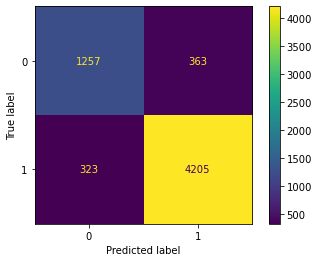

In [174]:
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

In [175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1620
           1       0.92      0.93      0.92      4528

    accuracy                           0.89      6148
   macro avg       0.86      0.85      0.86      6148
weighted avg       0.89      0.89      0.89      6148



In [176]:

print(pipeline.score(X_train,y_train))
print(pipeline.score(X_test,y_test))
     

0.9998605591577773
0.8884189980481457


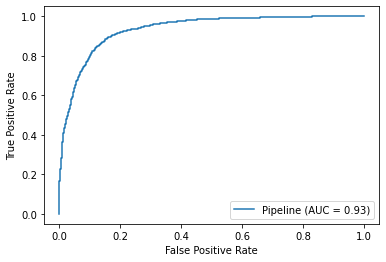

In [177]:
plot_roc_curve(pipeline,X_test,y_test);